In [55]:
import pandas as pd
import numpy as np

In [64]:
df = pd.read_csv('card transactions.csv')

In [65]:
df.head(5)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,1,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5142183973,1/1/10,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5142131721,1/1/10,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,5142148452,1/1/10,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
df.dropna(how='all',axis=1,inplace=True)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recnum             96753 non-null  int64  
 1   Cardnum            96753 non-null  int64  
 2   Date               96753 non-null  object 
 3   Merchnum           93378 non-null  object 
 4   Merch description  96753 non-null  object 
 5   Merch state        95558 non-null  object 
 6   Merch zip          92097 non-null  float64
 7   Transtype          96753 non-null  object 
 8   Amount             96753 non-null  float64
 9   Fraud              96753 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 7.4+ MB


In [68]:
df['Date'] = pd.to_datetime(df['Date'])
#remove all but P type transaction
df.drop(df.loc[df['Transtype']!='P'].index,inplace = True)

In [69]:
#identify the single outlier in Amount
df.Amount.sort_values(ascending = False).head(5)

52714    3102045.53
47339      47900.00
59516      30372.46
80886      28392.84
89673      27218.00
Name: Amount, dtype: float64

In [70]:
#remove outlier
df.drop(df.Amount.idxmax(),inplace = True)

In [71]:
#check
df.Amount.sort_values(ascending = False).head(5)

47339    47900.00
59516    30372.46
80886    28392.84
89673    27218.00
1103     26910.00
Name: Amount, dtype: float64

In [72]:
d#sanity check
df.Transtype.unique()

array(['P'], dtype=object)

# Data Cleaning

 **Missing Values** 

In [73]:
df.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3198
Merch description       0
Merch state          1020
Merch zip            4300
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

* Merchnum

In [74]:
#replace zeros with nan
df['Merchnum'] = df['Merchnum'].replace({'0':np.nan})

In [75]:
#check if each merch description only has one corresponding merchnum
group = df.groupby(['Merch description']).Merchnum.nunique()
(group != 1).sum()

1602

In [76]:
#create dictionary to store each merch description with corresponding merchnum
merch_merchnum = {}
for index, merch in df.loc[df['Merch description'].notnull() & df['Merchnum'].notnull(), 'Merch description'].items():
    if merch in merch_merchnum:
        merch_merchnum[merch].append(df.loc[index, 'Merchnum'])
    else:
        merch_merchnum[merch] = [df.loc[index, 'Merchnum']]



In [77]:
#impute each merch description with the mode of corresponding merchnum
import statistics

for merch in merch_merchnum:
  merch_merchnum[merch] = statistics.mode(merch_merchnum[merch])

In [78]:
#display first 5
list(merch_merchnum.items())[:5]
  

[('FEDEX SHP 12/23/09 AB#', '5509006296254'),
 ('SERVICE MERCHANDISE #81', '61003026333'),
 ('OFFICE DEPOT #191', '4503082993600'),
 ('FEDEX SHP 12/28/09 AB#', '5509006296254'),
 ('FEDEX SHP 12/22/09 AB#', '5509006296254')]

In [79]:
#fill the merchnum with value of records share the same merch descriptions
df['Merchnum'] = df['Merchnum'].fillna(df['Merch description'].map(merch_merchnum))

In [80]:
df['Merchnum'].isna().sum()

2094

In [81]:
#convert adjustment transactions with unknown 
df.loc[df['Merch description'].str.contains('ADJUSTMENT'), 'Merchnum'] = 'unknown'

In [82]:
df.loc[df['Merchnum'].isna(),'Merch description'].nunique()

504

In [83]:
create_merchnum = {}
n = 1
for index,merch in df.loc[df['Merchnum'].isna(),'Merch description'].items():
  if merch not in create_merchnum:
    create_merchnum[merch] = n+ max(pd.to_numeric(df['Merchnum'],errors = 'coerce'))
    n+=1



In [84]:
df['Merchnum'] = df['Merchnum'].fillna(df['Merch description'].map(create_merchnum))

In [85]:
df['Merchnum'].isna().sum()

0

* Merch state

In [86]:
df['Merch state'].isna().sum()

1020

In [87]:
#transfer the zipcode to standard format
df['Merch zip'] = df['Merch zip'].astype('str')
df.loc[df['Merch zip'].str.contains('nan'), 'Merch zip'] = None
df['Merch zip'] = df['Merch zip'].apply(lambda x: x[:-2] if pd.notnull(x) else x)
df['Merch zip'].isna().sum()

4300

In [88]:
us_zip = pd.read_csv('uszips.csv')

In [89]:
us_zip.head(5)

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18027,-66.75266,Adjuntas,PR,Puerto Rico,True,NaN,17126.0,102.6,72001,Adjuntas,"{""72001"": 98.73, ""72141"": 1.27}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36075,-67.17541,Aguada,PR,Puerto Rico,True,NaN,37895.0,482.5,72003,Aguada,"{""72003"": 100}",Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45744,-67.12225,Aguadilla,PR,Puerto Rico,True,NaN,49136.0,552.4,72005,Aguadilla,"{""72005"": 99.76, ""72099"": 0.24}",Aguadilla|Moca,72005|72099,False,False,America/Puerto_Rico
3,606,18.16585,-66.93716,Maricao,PR,Puerto Rico,True,NaN,5751.0,50.1,72093,Maricao,"{""72093"": 82.26, ""72153"": 11.68, ""72121"": 6.06}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29110,-67.12243,Anasco,PR,Puerto Rico,True,NaN,26153.0,272.1,72011,Añasco,"{""72011"": 96.71, ""72099"": 2.81, ""72083"": 0.37,...",Añasco|Moca|Las Marías|Aguada,72011|72099|72083|72003,False,False,America/Puerto_Rico


In [90]:
us_zip['zip'] = us_zip['zip'].astype('str')
us_zip = us_zip[['zip','state_id']]
us_zip.set_index('zip',inplace= True)
us_zip = us_zip['state_id'].to_dict()

In [91]:
#impute the missing state with corresponding zipcode within U.S
df['Merch state'].fillna(df['Merch zip'].map(us_zip),inplace = True)
df['Merch state'].isna().sum()

980

In [92]:
#create dictionary with merch description to corresponding state name
merch_state = {}
for index, merch in df.loc[df['Merch description'].notnull() & df['Merch state'].notnull(), 'Merch description'].items():
    if merch in merch_state:
        merch_state[merch].append(df.loc[index, 'Merch state'])
    else:
        merch_state[merch] = [df.loc[index, 'Merch state']]

#impute each merch description with the mode of corresponding mech description

for merch in merch_state:
  merch_state[merch] = statistics.mode(merch_state[merch])

In [93]:
#impute the missing state with corresponding merch description
df['Merch state'].fillna(df['Merch description'].map(merch_state),inplace = True)
df['Merch state'].isna().sum()

323

In [94]:
#create dictionary with merchnum to corresponding state name
merchnum_state = {}
for index, merch in df.loc[df['Merch state'].notnull(), 'Merchnum'].items():
    if merch in merchnum_state:
        merchnum_state[merch].append(df.loc[index, 'Merch state'])
    else:
        merchnum_state[merch] = [df.loc[index, 'Merch state']]

#impute each merch description with the mode of corresponding merchnum

for merch in merchnum_state:
  merchnum_state[merch] = statistics.mode(merchnum_state[merch])

In [95]:
#impute impute the missing state with corresponding merchnum
df['Merch state'].fillna(df['Merchnum'].map(merchnum_state),inplace = True)
df['Merch state'].isna().sum()

316

In [96]:
#set all the state name as foreign unknown for all the exsting zipcode that doesnt in US
for index,zip in df.loc[df['Merch state'].isnull(),'Merch zip'].items():
  if pd.notnull(zip):
    if zip not in us_zip.keys():
      df.loc[index,'Merch state'] = 'Foreign unknown'
df['Merch state'].isna().sum()

270

In [97]:
#assign unknown state name to adjustment transaction
df.loc[df['Merch description'].str.contains('ADJUSTMENT'), 'Merch state'] = 'unknown'

In [98]:
#fill the rest of merch state with unknowns
df['Merch state'].fillna('unknown',inplace = True)

In [99]:
df['Merch state'].isna().sum()

0

* Merch Zip

In [100]:
df['Merch zip'].isna().sum()

4300

In [101]:
#create dictionary with merchnum corresponding merch zip
merchnum_zip = {}
for index, merch in df.loc[df['Merch zip'].notnull(), 'Merchnum'].items():
    if merch in merchnum_zip:
        merchnum_zip[merch].append(df.loc[index, 'Merch zip'])
    else:
       merchnum_zip[merch] = [df.loc[index, 'Merch zip']]

#impute each merch description with the mode of corresponding merchnum

for merch in merchnum_zip:
  merchnum_zip[merch] = statistics.mode(merchnum_zip[merch])

In [102]:
#create dictionary with merch description corresponding merch zip
merch_zip = {}
for index, merch in df.loc[df['Merch zip'].notnull(), 'Merch description'].items():
    if merch in merch_zip:
        merch_zip[merch].append(df.loc[index, 'Merch zip'])
    else:
       merch_zip[merch] = [df.loc[index, 'Merch zip']]

#impute each merch zip with the mode of corresponding merch description

for merch in merch_zip:
  merch_zip[merch] = statistics.mode(merch_zip[merch])

In [103]:
#create dictionary with state name corresponding merch zip
state_zip = {}
for index, merch in df.loc[df['Merch zip'].notnull(), 'Merch state'].items():
    if merch in state_zip:
        state_zip[merch].append(df.loc[index, 'Merch zip'])
    else:
        state_zip[merch] = [df.loc[index, 'Merch zip']]

#impute each merch description with the mode of corresponding merch state

for merch in state_zip:
  state_zip[merch] = statistics.mode(state_zip[merch])

In [104]:
#impute zipcode with mode of corresponding merhnum, merch description, and merch state
df['Merch zip'].fillna(df['Merchnum'].map(merchnum_zip),inplace = True)
df['Merch zip'].fillna(df['Merch description'].map(merch_zip),inplace = True)
df['Merch zip'].fillna(df['Merch state'].map(state_zip),inplace = True)
df['Merch zip'].isna().sum()

185

In [105]:
 #assign unknown to adjustment transaction
df.loc[df['Merch description'].str.contains('ADJUSTMENT'), 'Merch zip'] = 'unknown'

In [106]:
df['Merch zip'].fillna('unknown',inplace = True)
df['Merch zip'].isna().sum()

0

In [107]:
#right alignment
df['Merch zip']=df['Merch zip'].apply(lambda x:'{0:0>5}'.format(x))

# Create Variables

In [53]:
final=df.copy()
df['check_date']=df.Date
df['check_record']=df.Recnum
numvars = 1
final.shape

(96396, 10)

* **Risk Table Variable**

In [54]:
import calendar
#likelihood of fraud for that day of the week
df['Dow'] = df.Date.apply(lambda x: calendar.day_name[x.weekday()])
#exclude OOT
train_test = df[df.Date <= '2010-11-01']
c=4
nmid=20
y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('Dow')['Fraud'].mean()
num = train_test.groupby('Dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1+np.exp(-(num-nmid)/c))
df['Dow_Risk'] = df.Dow.map(y_dow_smooth)

numvars += 1

y_dow_smooth

Dow
Friday       0.025994
Monday       0.008610
Saturday     0.010095
Sunday       0.009630
Thursday     0.018626
Tuesday      0.007127
Wednesday    0.009788
dtype: float64

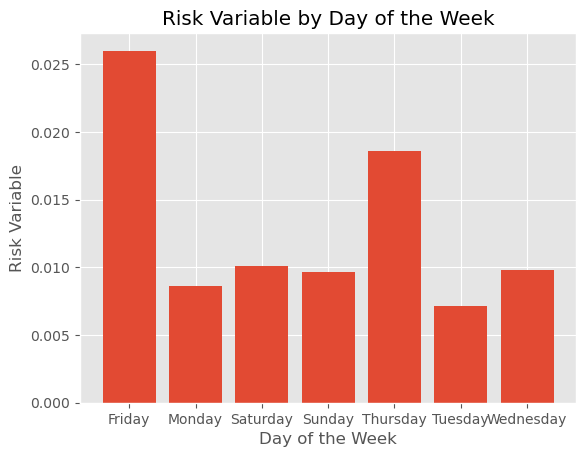

In [55]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.bar(y_dow_smooth.index, y_dow_smooth)
plt.xlabel('Day of the Week')
plt.ylabel('Risk Variable')
plt.title('Risk Variable by Day of the Week')
plt.show()


* **Foreign Tag**

In [58]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

us_state_abbrev_list = list(us_state_abbrev.values())
us_state_abbrev_list.append('VI')
us_state_abbrev_list.append('PR')
us_state_abbrev_list.append('unknown')

#tag non-US states

df['Foriegn tag'] = 0

for index, state in df['Merch state'].items( ):
    if state not in us_state_abbrev_list:
        df.loc[index,'Foriegn tag'] = 1

numvars += 1

df['Foriegn tag'].value_counts()

0    92952
1     3444
Name: Foriegn tag, dtype: int64

* **Benford's Law variable (Ignored)**


In [59]:

bf= df.copy()
bf['amount_100'] = (bf['Amount']*100).astype(str)
bf['first_digit'] = bf['amount_100'].str[0]
dropfedex = bf[bf['Merch description'].str.contains('FEDEX')]
droplist = dropfedex.index.to_list()
bf1 = bf.drop(droplist)
bf1['bin'] = bf1['first_digit'].apply(lambda x: 'low' if (x == '1' or x == '2') else 'high')
bf1['bin'].value_counts()

high    43097
low     41524
Name: bin, dtype: int64

In [60]:

card_bf = bf1.groupby(['Cardnum','bin']).agg({'bin': ['count']}).reset_index()
card_bf.columns = ['Cardnum','bin','count']
card_bf = card_bf.pivot_table(index='Cardnum',columns = 'bin',values='count',aggfunc='sum').reset_index()
card_bf.columns = ['Cardnum','n_high','n_low']
card_bf = card_bf.fillna(1)
card_bf


,Cardnum,n_high,n_low
0,5142110002,1.0,1.0
1,5142110081,4.0,1.0
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,1.0,1.0
...,...,...,...
1635,5142310397,1.0,1.0
1636,5142310525,3.0,1.0
1637,5142310598,1.0,2.0
1638,5142310768,2.0,2.0


In [61]:

#calculating R, 1/R, U, n, t U_smoothed
from math import exp
c=3
n_mid=15
card_bf['R'] = (1.096 *card_bf['n_low']/card_bf['n_high'])
card_bf['1/R'] = 1/card_bf['R']
card_bf['U'] = list(map(lambda x,y :max(x,y),card_bf['R'],card_bf['1/R']))
card_bf['n'] = card_bf['n_low']+card_bf['n_high']
card_bf['t'] = (card_bf['n'] - n_mid)/c
#statistical smoothing
card_bf['U_smoothed'] = list(map(lambda x,y: (1 + (x-1)/(1+exp(-y))), card_bf['U'],card_bf['t']))

card_bf['U_smoothed']


0       1.001244
1       1.091267
2       1.021440
3       1.298955
4       1.001244
          ...   
1635    1.001244
1636    1.043299
1637    1.021440
1638    1.002393
1639    3.193331
Name: U_smoothed, Length: 1640, dtype: float64

In [62]:

merch_bf = bf1.groupby(['Merchnum','bin']).agg({'bin': ['count']}).reset_index()
merch_bf.columns = ['Merchnum','bin','count']
merch_bf = merch_bf.pivot_table(index='Merchnum',columns = 'bin',values='count',aggfunc='sum').reset_index()
merch_bf.columns = ['Merchnum','n_high','n_low']
merch_bf = merch_bf.fillna(1)
merch_bf


,Merchnum,n_high,n_low
0,9996060597901.0,1.0,3.0
1,9996060597902.0,1.0,1.0
2,9996060597903.0,2.0,1.0
3,9996060597904.0,3.0,5.0
4,9996060597905.0,2.0,7.0
...,...,...,...
13582,DU49038320006,1.0,1.0
13583,JCPENNE9 CO,2.0,1.0
13584,PENNE9 CO #05,1.0,1.0
13585,PENNE9 CO #68,1.0,1.0


In [63]:
#calculating R, 1/R, U, n, t U_smoothed

merch_bf['R'] = (1.096 * merch_bf['n_low']/merch_bf['n_high'])
merch_bf['1/R'] = 1/merch_bf['R']
merch_bf['U'] = list(map(lambda x,y :max(x,y),merch_bf['R'],merch_bf['1/R']))
merch_bf['n'] = merch_bf['n_low']+merch_bf['n_high']
merch_bf['t'] = (merch_bf['n'] - n_mid)/c
#statistical smoothing
merch_bf['U_smoothed'] = list(map(lambda x,y: (1 + (x-1)/(1+exp(-y))), merch_bf['U'], merch_bf['t']))

merch_bf['U_smoothed']


0        1.057027
1        1.001244
2        1.014835
3        1.073077
4        1.338059
           ...   
13582    1.001244
13583    1.014835
13584    1.001244
13585    1.001244
13586    1.381648
Name: U_smoothed, Length: 13587, dtype: float64

In [64]:

card_bf['Cardnum'] = card_bf['Cardnum'].apply(str)
merch_bf['Merchnum'] = merch_bf['Merchnum'].apply(str)


In [65]:

card_bf.set_index('Cardnum',inplace=True)
card_Ustar = pd.DataFrame(card_bf['U_smoothed'])
card_bf.sort_values(['U_smoothed'],ascending=False).head(3)


,n_high,n_low,R,1/R,U,n,t,U_smoothed
Cardnum,,,,,,,,
5142253356,5.0,61.0,13.371200,0.074788,13.371200,66.0,17.000000,13.371199
5142299705,3.0,25.0,9.133333,0.109489,9.133333,28.0,4.333333,9.027976
5142197563,134.0,15.0,0.122687,8.150852,8.150852,149.0,44.666667,8.150852


In [66]:
merch_bf.set_index('Merchnum',inplace=True)
merch_Ustar = pd.DataFrame(merch_bf['U_smoothed'])
merch_bf.sort_values(['U_smoothed'],ascending=False).head(3)

,n_high,n_low,R,1/R,U,n,t,U_smoothed
Merchnum,,,,,,,,
991808369338,181.0,1.0,0.006055,165.145985,165.145985,182.0,55.666667,165.145985
8078200641472,1.0,59.0,64.664000,0.015465,64.664000,60.0,15.000000,64.663981
308904389335,53.0,1.0,0.020679,48.357664,48.357664,54.0,13.000000,48.357557


In [67]:
#add variables to the dataset
df['Cardnum'] = df['Cardnum'].astype('str')
df['Cardnum'] = df['Merchnum'].astype('str')
df = df.merge(card_Ustar,how ='left',left_on = 'Cardnum',right_on = card_Ustar.index)
df = df.rename(columns = {'U_smoothed':'U*_cardnum'})
df = df.merge(merch_Ustar,how ='left',left_on = 'Merchnum',right_on = merch_Ustar.index)
df = df.rename(columns = {'U_smoothed':'U*_merchnum'})
df.head()


,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,check_date,check_record,Dow,Dow_Risk,Foriegn tag,U*_cardnum,U*_merchnum
0,1,5509006296254,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,2010-01-01,1,Friday,0.025994,0,NaN,NaN
1,2,61003026333,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0,2010-01-01,2,Friday,0.025994,0,NaN,1.001244
2,3,4503082993600,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,2010-01-01,3,Friday,0.025994,0,NaN,1.025818
3,4,5509006296254,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,2010-01-01,4,Friday,0.025994,0,NaN,NaN
4,5,5509006296254,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,2010-01-01,5,Friday,0.025994,0,NaN,NaN


* **Entities**



In [68]:

# Make new entities for variables

df['card_merch']=str(df['Cardnum']) + str(df.Merchnum)
df['card_zip']=str(df.Cardnum) + str(df['Merch zip'])
df['card_state']=str(df.Cardnum) + df['Merch state']
df['merch_zip']=str(df.Merchnum) + str(df['Merch zip'])
df['merch_state']=str(df.Merchnum) + df['Merch state']

In [69]:
df.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       'check_date', 'check_record', 'Dow', 'Dow_Risk', 'Foriegn tag',
       'U*_cardnum', 'U*_merchnum', 'card_merch', 'card_zip', 'card_state',
       'merch_zip', 'merch_state'],
      dtype='object')

In [70]:
df.shape

(96396, 22)

In [73]:
entities=list(df.iloc[:,np.r_[1, 3, 5, 6, 17:22]].columns)
entities

['Cardnum',
 'Merchnum',
 'Merch state',
 'Merch zip',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state']

In [74]:
len(entities)

9

In [75]:
df.to_csv('cleaned_transaction_data.csv')

* **Day Since & Frequency & Amount Variables**

In [52]:
import pandas as pd
import numpy as np
#this code is used for rerun (kernel die problem)
final = pd.read_csv('final_variables.csv',index_col = 0)


In [17]:
df = pd.read_csv('cleaned_transaction_data.csv',index_col = 0)

In [18]:
entities=list(df.iloc[:,np.r_[1, 3, 5, 6, 17:22]].columns)
entities

['Cardnum',
 'Merchnum',
 'Merch state',
 'Merch zip',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state']

In [19]:
final['Date'] = pd.to_datetime(final['Date'])
df['Date'] = pd.to_datetime(df['Date'])
df['check_date'] = pd.to_datetime(df['check_date'])

In [ ]:
import timeit
import datetime as dt
start = timeit.default_timer()
for entity in entities:    
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    
    ## Day-since variables:   
    df_l = df[['Recnum', 'Date', entity]]
    df_r = df[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')   
    ## Frequency & Amount variables:   
    for time in [0,1,3,7,14,30]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')

In [ ]:
#create day since variables in 60 days
import timeit
import datetime as dt
start = timeit.default_timer()

#run first 5 entities to reduce memory usage
for entity in entities[:5]:    
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    
    ## Day-since variables:   
    df_l = df[['Recnum', 'Date', entity]]
    df_r = df[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')   
    ## Frequency & Amount variables:   
    for time in [60]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
       e final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')

In [35]:
final.to_csv('finals_version1.csv')

In [ ]:
#skip the merch description (4th entities always crush)
import timeit
import datetime as dt
start = timeit.default_timer()
for entity in entities[6:]:    
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    
    ## Day-since variables:   
    df_l = df[['Recnum', 'Date', entity]]
    df_r = df[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')   
    ## Frequency & Amount variables:   
    for time in [60]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')

* **Average Relative Velocity  Variable**

In [9]:
import timeit
import datetime as dt
start = timeit.default_timer()

In [10]:
start = timeit.default_timer()
# average relative velocity
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)
            

In [12]:
final['Merchnum_count_0_by_7']

0        0.142857
1        0.142857
2        0.142857
3        0.142857
4        0.142857
           ...   
96748    0.142857
96749    0.142857
96750    0.095238
96751    0.023810
96752    0.047619
Name: Merchnum_count_0_by_7, Length: 96397, dtype: float64

* **Velocity Days Since Variable**

In [11]:
start = timeit.default_timer()
# velocity days since ratio
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30']:
            final[ent + '_vdratio_' + d  + 'by' + dd] =\
            final[ent + '_count_' + d + '_by_' + dd]/(final[ent + '_day_since']+1)


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2040162364.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d  + 'by' + dd] =\
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2040162364.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d  + 'by' + dd] =\
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2040162364.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

In [16]:
final['Merchnum_vdratio_0by7']

0        0.142857
1        0.142857
2        0.142857
3        0.142857
4        0.142857
           ...   
96748    0.000391
96749    0.014286
96750    0.095238
96751    0.011905
96752    0.015873
Name: Merchnum_vdratio_0by7, Length: 96397, dtype: float64

In [17]:
#save the version 2 final in case of kernel die in following cells
final.to_csv('final_vesion2.csv')

* **Cross entity uniqueness variables**

In [27]:
# Cross entity uniqueness variables
for entity in entities: 
    for field in entities:
        st = timeit.default_timer()
        if entity != field:
            new_attributes = f'{entity}_{field}_nunique'
            if new_attributes not in list(final.columns):
                mapper3 = df.groupby(entity)[field].nunique()
                final[new_attributes] = df[entity].map(mapper3)
        print(f'Run time for entity {entity} in field {field}'+ ' ---> Done')

Run time for entity Cardnum in field Cardnum ---> Done
Run time for entity Cardnum in field Merchnum ---> Done
Run time for entity Cardnum in field Merch state ---> Done
Run time for entity Cardnum in field Merch zip ---> Done
Run time for entity Cardnum in field card_merch ---> Done
Run time for entity Cardnum in field card_zip ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity Cardnum in field card_state ---> Done
Run time for entity Cardnum in field merch_zip ---> Done
Run time for entity Cardnum in field merch_state ---> Done
Run time for entity Merchnum in field Cardnum ---> Done
Run time for entity Merchnum in field Merchnum ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity Merchnum in field Merch state ---> Done
Run time for entity Merchnum in field Merch zip ---> Done
Run time for entity Merchnum in field card_merch ---> Done
Run time for entity Merchnum in field card_zip ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity Merchnum in field card_state ---> Done
Run time for entity Merchnum in field merch_zip ---> Done
Run time for entity Merchnum in field merch_state ---> Done
Run time for entity Merch state in field Cardnum ---> Done
Run time for entity Merch state in field Merchnum ---> Done
Run time for entity Merch state in field Merch state ---> Done
Run time for entity Merch state in field Merch zip ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity Merch state in field card_merch ---> Done
Run time for entity Merch state in field card_zip ---> Done
Run time for entity Merch state in field card_state ---> Done
Run time for entity Merch state in field merch_zip ---> Done
Run time for entity Merch state in field merch_state ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity Merch zip in field Cardnum ---> Done
Run time for entity Merch zip in field Merchnum ---> Done
Run time for entity Merch zip in field Merch state ---> Done
Run time for entity Merch zip in field Merch zip ---> Done
Run time for entity Merch zip in field card_merch ---> Done
Run time for entity Merch zip in field card_zip ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity Merch zip in field card_state ---> Done
Run time for entity Merch zip in field merch_zip ---> Done
Run time for entity Merch zip in field merch_state ---> Done
Run time for entity card_merch in field Cardnum ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity card_merch in field Merchnum ---> Done
Run time for entity card_merch in field Merch state ---> Done
Run time for entity card_merch in field Merch zip ---> Done
Run time for entity card_merch in field card_merch ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity card_merch in field card_zip ---> Done
Run time for entity card_merch in field card_state ---> Done
Run time for entity card_merch in field merch_zip ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity card_merch in field merch_state ---> Done
Run time for entity card_zip in field Cardnum ---> Done
Run time for entity card_zip in field Merchnum ---> Done
Run time for entity card_zip in field Merch state ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity card_zip in field Merch zip ---> Done
Run time for entity card_zip in field card_merch ---> Done
Run time for entity card_zip in field card_zip ---> Done
Run time for entity card_zip in field card_state ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity card_zip in field merch_zip ---> Done
Run time for entity card_zip in field merch_state ---> Done
Run time for entity card_state in field Cardnum ---> Done
Run time for entity card_state in field Merchnum ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity card_state in field Merch state ---> Done
Run time for entity card_state in field Merch zip ---> Done
Run time for entity card_state in field card_merch ---> Done
Run time for entity card_state in field card_zip ---> Done
Run time for entity card_state in field card_state ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity card_state in field merch_zip ---> Done
Run time for entity card_state in field merch_state ---> Done
Run time for entity merch_zip in field Cardnum ---> Done
Run time for entity merch_zip in field Merchnum ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity merch_zip in field Merch state ---> Done
Run time for entity merch_zip in field Merch zip ---> Done
Run time for entity merch_zip in field card_merch ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity merch_zip in field card_zip ---> Done
Run time for entity merch_zip in field card_state ---> Done
Run time for entity merch_zip in field merch_zip ---> Done
Run time for entity merch_zip in field merch_state ---> Done
Run time for entity merch_state in field Cardnum ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity merch_state in field Merchnum ---> Done
Run time for entity merch_state in field Merch state ---> Done
Run time for entity merch_state in field Merch zip ---> Done
Run time for entity merch_state in field card_merch ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Run time for entity merch_state in field card_zip ---> Done
Run time for entity merch_state in field card_state ---> Done
Run time for entity merch_state in field merch_zip ---> Done
Run time for entity merch_state in field merch_state ---> Done


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/2589271082.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[new_attributes] = df[entity].map(mapper3)


* **Velocity Change**

In [26]:
# frequencies
import timeit
import datetime as dt
start = timeit.default_timer()
df2 = df.copy()
df2['check_date'] = df2.Date
df2['check_recnum'] = df2.Recnum
df_2 = df2[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum']]
df_s = df2[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum']]
temp2 = pd.merge(df_2, df_s, left_on = 'Cardnum', right_on = 'Cardnum')

#Frequency Mappers
# groupers = ['Cardnum', 'Merchnum']
groupers = ['Cardnum']
for grouper in groupers: 
    for d in [0,1]:
        for dd in [3,7,14,30]:
            numerator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(d)))
                               & (temp2.Recnum >= temp2.check_recnum)]
            denominator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(dd)))
                               & (temp2.Recnum >= temp2.check_recnum)]

            numerator = numerator_df.groupby(grouper)['Recnum'].count()
            denominator = denominator_df.groupby(grouper)['Recnum'].count()/dd

            colname = 'velocity_change_count_by_' + grouper + '_' + str(d) + '_days_over_' + str(dd)

            final[colname] = final[grouper].map(numerator)/final[grouper].map(denominator)

In [26]:
df2 = df.copy()
df2['check_date'] = df2.Date
df2['check_recnum'] = df2.Recnum
df_2 = df2[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum']]
df_s = df2[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum']]
temp2 = pd.merge(df_2, df_s, left_on = 'Merchnum', right_on = 'Merchnum')

#Frequency Mappers
# groupers = ['Cardnum', 'Merchnum']
groupers = ['Merchnum']
for grouper in groupers: 
    for d in [0,1]:
        for dd in [3,7,14,30]:
            numerator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(d)))
                               & (temp2.Recnum >= temp2.check_recnum)]
            denominator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(dd)))
                               & (temp2.Recnum >= temp2.check_recnum)]

            numerator = numerator_df.groupby(grouper)['Recnum'].count()
            denominator = denominator_df.groupby(grouper)['Recnum'].count()/dd

            colname = 'velocity_change_count_by_' + grouper + '_' + str(d) + '_days_over_' + str(dd)

            final[colname] = final[grouper].map(numerator)/final[grouper].map(denominator)

/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/794439165.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[colname] = final[grouper].map(numerator)/final[grouper].map(denominator)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/794439165.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[colname] = final[grouper].map(numerator)/final[grouper].map(denominator)
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/794439165.py:24: PerformanceWarning: DataFrame is highl

* **Variability** 

In [ ]:
df1 = data.copy()
df1['check_date'] = df1.Date
df1['check_recnum'] = df1.Recnum

In [ ]:
# variability

for entity in entities:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: 
        print('')
    st = timeit.default_timer() 
    df_l = df1[['Recnum', 'Date', entity,'Amount']]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    
    for time in [0,1,3,7,14,30]:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', 'check_record',entity, 'Amount_x','Amount_y']]
        temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']

        col_name = entity + '_variability_avg_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].mean()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_max_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].max()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_med_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].median()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')

* **Unique Count**

In [ ]:
for i in entities:
    for v in entities:
        if i==v:
            continue
        else:
            df_c=df1[['Recnum','Date',i]]
            df_d=df1[['check_record','check_date',i,v]]
            temp=pd.merge(df_c,df_d,left_on=i,right_on=i)
            
        for t in [1,3,7,14,30]:
            count_day_df=temp[(temp.check_date>=(temp.Date-dt.timedelta(t)))&(temp.Recnum>=temp.check_record)]
            col_name=f'{i}_unique_count_for_{v}_{t}'
            mapper=count_day_df.groupby(['Recnum'])[v].nunique()
            final[col_name]=final.Recnum.map(mapper)

* **Amount**

In [ ]:
# Amount bins
AMOUNT = True
if AMOUNT:
      final['amount_cat'] = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5])
      
      final['amount_cat'].value_counts().plot(kind='barh')
      plt.show()
      
      qcut_series, qcut_intervals = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5],retbins=True)
      
      qcut_series.value_counts()

In [22]:
final['amount_cat']

0        1
1        2
2        3
3        1
4        1
        ..
96748    2
96749    3
96750    4
96751    5
96752    5
Name: amount_cat, Length: 96397, dtype: int64

* **Acceleration**

In [21]:
# acceleration
for ent in entities:
    print(ent)
    for d in ['0', '1']:
        for dd in ['7', '14', '30']:
            final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/pow(float(dd),2)


Cardnum
Merchnum
Merch state
Merch zip
card_merch
card_zip
card_state
merch_zip
merch_state


/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/3222937936.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/3222937936.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/2f/fpszyvs50jl1c4sw9dlynhjm0000gn/T/ipykernel_78807/3222937936.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [3]:
! jupyter trust Make_Variables_Project2.ipynb 

Notebook already signed: Make_Variables_Project2.ipynb


In [28]:
final.shape

(96397, 1068)

In [ ]:
final.to_csv('final_variabless.csv')